In [1]:
## Initial Exploration of the 311 data
#####################################################################
# This file explores the Analyze Boston 311 data
# to import the data we must first run the import-311-data.py file
# this file also loads pandas
#####################################################################
import matplotlib.pyplot as plt

%run -t import-311-data.py

/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-crime/02 code/import-311-data.py:24: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]
/Users/jacobpstein/Documents/Georgetown SCS/capstone/boston-crime/02 code/import-311-data.py:24: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(url) for url in urls]



IPython CPU timings (estimated):
  User   :      20.72 s.
  System :      10.10 s.
Wall time:     209.06 s.


In [3]:
# let's see how many rows and columns we have
df_311.shape

(2408011, 33)

In [4]:
# total unique observations per column
df_311.nunique()

case_enquiry_id                   2408011
open_dt                           2191239
target_dt                         1264612
closed_dt                         2140771
ontime                                  2
case_status                             2
closure_reason                    1777824
case_title                          23043
subject                                14
reason                                 54
type                                  210
queue                                 193
department                             18
submittedphoto                     701342
closedphoto                        354100
location                           146375
fire_district                          12
pwd_district                           22
city_council_district                  11
police_district                        24
neighborhood                           24
neighborhood_services_district         17
ward                                   56
precinct                          

<AxesSubplot:xlabel='date'>

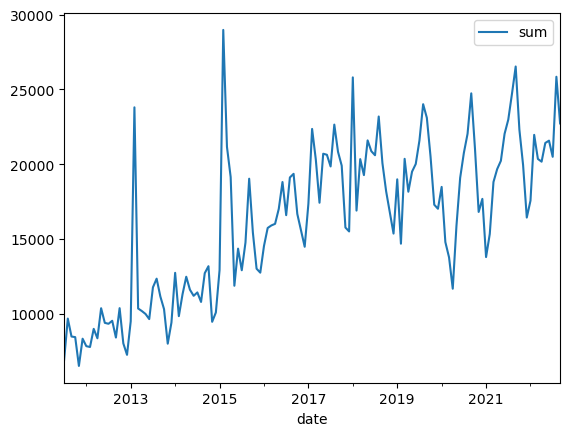

In [5]:
# get the total number of closed calls by month
closed_calls = df_311.groupby(['close_date']).agg({'closed': ['sum']}).reset_index()

# rename the columns
closed_calls.columns = ['date', 'sum']

# set date as the row index
closed_calls = closed_calls.set_index("date")

# take a look
closed_calls.plot()

In [6]:
# it looks like there is some clear seasonality in our data

df_311['close_month'] = df_311['closed_dt'].dt.month
close_month = df_311.groupby(['close_month']).agg({'closed': ['sum']}).reset_index()
close_month.columns = ['month', 'sum']

close_month.sort_values('sum', ascending=False)

,month,sum
7,8.0,218710
8,9.0,217197
6,7.0,195245
1,2.0,192216
5,6.0,187646
2,3.0,181712
4,5.0,180220
9,10.0,176429
3,4.0,172590
0,1.0,169557
